In [35]:
import importlib
import experiment
importlib.reload(experiment)
import models
importlib.reload(models)
from experiment import *


In [36]:
exp_name = "DCP2_DCP1-FL"

from pathlib import Path
path = Path("./data/$DCP2-DCP1-FL_230125/MCK_$DCP2_VS_DCP1-FL")
fs = sorted(list(path.glob("*.csv")))

controls_path = Path("./data/$DCP2-DCP1-FL_230125/MCK_$DCP2_VS_DCP1-FL_refs")
controls_fs = sorted(list(controls_path.glob("*.csv")))
print(len(fs))
print(len(controls_fs))

14
6


Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <Axes: >)

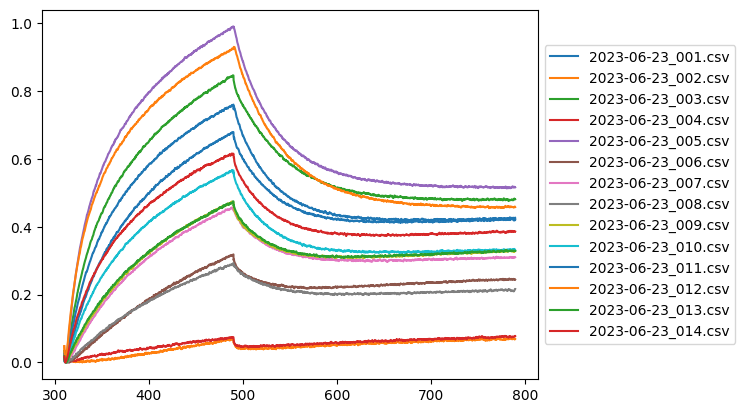

In [37]:
exp = Exp()
exp.load_bli_data(fs)
exp.interstep_correction()


#remove loading and baselines because you forgot to do that in exp class 
for ds in exp:
    s = ds.steps[0].start
    mask = ds.t >= s
    ds.response = ds.response[mask]
    ds.t = ds.t[mask]

exp.interstep_correction()

#correct vs min
for ds in exp:
    min_val = ds.response.min()
    ds.response = ds.response - min_val

exp.plot()

Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <Axes: >)

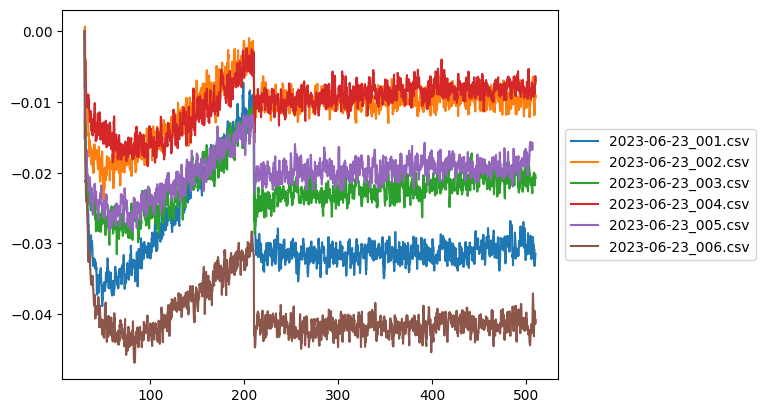

In [38]:
controls = Exp()
controls.load_bli_data(controls_fs)
controls.interstep_correction()
controls.plot()


In [39]:
#load descriptions, need to copy from blitz
desc = Path(f"./data/$DCP2-DCP1-FL_230125/desc.txt")
df = pd.read_csv(desc, sep='\t', index_col=0)
df

,Show,Analyze,Ref.,Sample ID,Conc. (uM),Run time (s),Shaker speed (rpm),Integration (ms),Biosensor Type,Information,Status
Index,,,,,,,,,,,
1,1,1,0,NaN,3.2,790,1000,1.7,SA,"fresh 0.5uM $DCP2, 3.2uMSumo-Dcp1A (stock 50uM)",NaN
2,1,0,0,NaN,0.1,790,1000,1.6,SA,NaN,NaN
3,1,1,0,NaN,6.4,790,1000,1.6,SA,NaN,NaN
4,1,1,0,NaN,0.0,790,1000,1.6,SA,NaN,NaN
5,1,1,0,NaN,15.0,790,1000,1.7,SA,NaN,NaN
6,1,1,0,NaN,0.8,790,1000,1.7,SA,NaN,NaN
7,1,1,0,NaN,1.6,790,1000,1.7,SA,NaN,NaN
8,1,1,0,NaN,0.8,790,1000,1.7,SA,NaN,NaN
9,1,1,0,NaN,1.6,790,1000,1.7,SA,NaN,NaN


In [40]:
sorted(df['Conc. (uM)'])


[0.0, 0.1, 0.8, 0.8, 1.6, 1.6, 1.6, 3.2, 3.2, 3.2, 6.4, 6.4, 15.0, 15.0]

In [41]:
#assign concentrations from desc to each dataset
concs = df['Conc. (uM)'].to_dict()
analyze = df['Analyze'].to_dict()

for ds in exp.datasets:
    idx = ds.name[:-4].split('_')[-1]
    idx=int(idx)
    c = concs[idx]
    if np.isnan(c): c=0
    ds.steps[0].concentration = c*1e-6
    ds.use_for_fit = analyze[idx]



In [42]:
exp.datasets[3].use_for_fit=False
exp.datasets[1].use_for_fit=False
exp.datasets[1].steps[0].concentration = False
exp.datasets[3]

Dataset(3, name = 2023-06-23_004.csv, no_steps = 2, len = 479.79999999999995, baseline = (210.0, 310.0), use_for_fit = False)

3.2e-06
ds0: correcting c= 3.2e-06
6.4e-06
ds2: correcting c= 6.4e-06
1.4999999999999999e-05
ds4: correcting c= 1.4999999999999999e-05
8e-07
ds5: correcting c= 8e-07
1.6e-06
ds6: correcting c= 1.6e-06
8e-07
ds7: correcting c= 8e-07
1.6e-06
ds8: correcting c= 1.6e-06
3.2e-06
ds9: correcting c= 3.2e-06
6.4e-06
ds10: correcting c= 6.4e-06
1.4999999999999999e-05
ds11: correcting c= 1.4999999999999999e-05
1.6e-06
ds12: correcting c= 1.6e-06
3.2e-06
ds13: correcting c= 3.2e-06
Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <Axes: >)

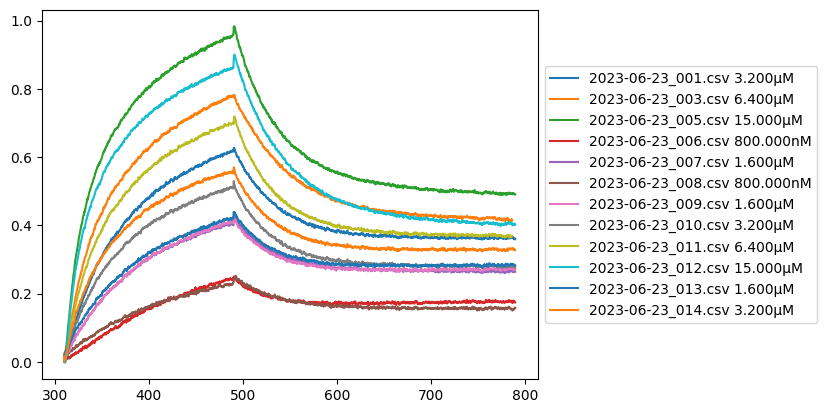

In [43]:
#subtract controls from ds

controls_dict = {}
controls_concs = [0., 0.8, 1.6, 3.2, 6.4, 15]
controls_concs = [c*1e-6 for c in controls_concs]

for ds, c in zip(controls, controls_concs):
    control_mask = ds.t>=ds.steps[0].start
    ds.steps[0].concentration = c
    controls_dict[c] = ds.response[control_mask]

mask = exp.datasets[3].t>=exp.datasets[3].steps[0].start
control_lig = exp.datasets[3].response[mask]
for ds in exp:
    if not ds.use_for_fit: continue
    print(ds.steps[0].concentration)
    start = ds.steps[0].start
    mask = ds.t>=start
    r = ds.response[mask]
    c = ds.steps[0].concentration

    if c in controls_dict:
        print(f'ds{ds.index}: correcting c=',c)
        ds.response[mask] = np.subtract(r, controls_dict[c])
    ds.response[mask] = np.subtract(ds.response[mask], control_lig)

        
exp.interstep_correction()
exp.plot()

In [44]:
exp.no_datasets

14

removing ds 1
removing ds 3
Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <Axes: >)

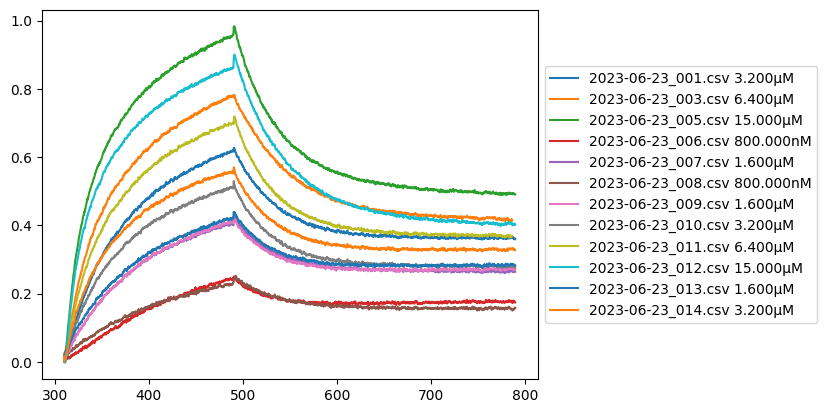

In [45]:
#remove some datasets
manual_remove = []# [10, 2]
ds_to_remove = []
for ds in exp:
    if ds.use_for_fit == False:
        ds_to_remove.append(ds)
    if ds.index in manual_remove:
        ds_to_remove.append(ds)
        
for ds in ds_to_remove:
    print(f'removing ds {ds.index}')
    exp.datasets.remove(ds)

exp.interstep_correction()
exp.plot()

In [46]:
exp.model = models.Bivalent_analyte()
exp.model.params_definitions

{'ka1': <Parameter 'ka1', value=10000.0, bounds=[10.0:100000000.0]>,
 'kd1': <Parameter 'kd1', value=0.01, bounds=[1e-06:0.1]>,
 'ka2': <Parameter 'ka2', value=0.01, bounds=[1e-07:10000000.0]>,
 'kd2': <Parameter 'kd2', value=0.01, bounds=[1e-07:10000000.0]>,
 'kt': <Parameter 'kt', value=10000000.0, bounds=[10.0:1000000000000.0]>,
 'ymax': <Parameter 'ymax', value=1, bounds=[0:1000]>,
 'offset': <Parameter 'offset', value=0, bounds=[-10:10]>}

In [47]:
# exp.model.params_definitions['ymax'].user_data['type']='global'

#exp.model.params_definitions['ymax1'].user_data['type']='global'
#exp.model.params_definitions['ymax2'].user_data['type']='global'

# exp.model.params_definitions['ka1'].value = 500
# exp.model.params_definitions['kd1'].min = 1e-12

exp.create_params(offsets=1, mtl = 0, define_ymax = 'local_dataset')
#exp.params


In [48]:
exp.fit_params()

Nan and inf are not valid responses. Some values in dataset 2 are not finite. LMFIT is set to omit.
Nan and inf are not valid responses. Some values in dataset 10 are not finite. LMFIT is set to omit.
fitting using: least_squares


'`ftol` termination condition is satisfied.'

(<Figure size 640x480 with 1 Axes>, <Axes: >)

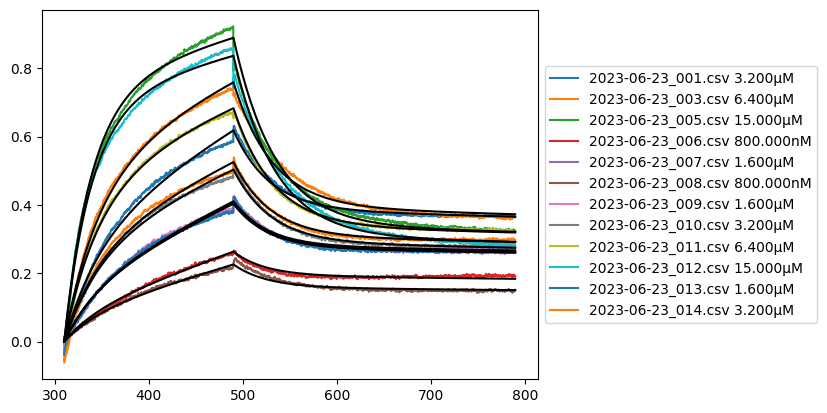

In [49]:
flag = False
for par in exp.params:
    if "offset" in par:
        flag=True

exp.plot(fit=True, correct_offsets=flag)

In [63]:
import plotly.graph_objects as go

fig = go.Figure()

for ds in exp.datasets:
    if ds.use_for_fit == False: continue
    x = np.array([])
    y = np.array([])
    y_fit = np.array([])
    
    for step in ds.steps:
        # if step.concentration>0: color = 'orangered'
        # elif step.concentration==0: color = 'cornflowerBlue'
        # else: color = 'lightgrey'
        mask = (ds.t>=step.start) & (ds.t<step.stop)

        if f"offset_ds{ds.index}_step{step.index}" in exp.params:
                offset = exp.params[f'offset_ds{ds.index}_step{step.index}'].value
        else: 
            offset = 0
        
        x_step = ds.t[mask]
        y_step = ds.response[mask] - offset
        y_fit_step = ds.fit_response[mask] - offset

        x = np.concatenate([x, x_step])
        y = np.concatenate([y, y_step])
        y_fit = np.concatenate([y_fit, y_fit_step])

    
    x = x - x[0]
    fig.add_scatter(x = x, 
                    y = y_fit,
                    marker=dict(size=0, 
                            color='black',
                            line=dict(width=1, color='black')),
                    line=dict(
                         width=2, 
                         color='black'
                         ),
                    name=ds.steps[0].concentration,)

        

    fig.add_scatter(x = x,
                    y = y,
                    marker=dict(
                            size=0, 
                            #color=color, 
                            line=dict(
                                    width=0.1, 
                                    #color=color
                                    )),
                    line=dict(
                            width=1, 
                            #color=color
                            ),
                    name=f"{ds.index}_{ds.steps[0].concentration}",
                    )



fig.update_layout(
            height=600,
            width = 800,
            font_family="Arial",
            font_size = 24,
            showlegend=False,
            margin=dict(l=0,r=0,b=0,t=0,pad=0), 
            template='plotly_white',
            paper_bgcolor="rgb(255, 255, 255)",  
            plot_bgcolor="rgb(255, 255, 255)") 

fig.update_xaxes(
    ticklabelposition="inside top", 
    title='time [s]',
    showline=True, 
    linewidth=1, 
    linecolor='black', 
    showgrid=False,
    mirror=True)

fig.update_yaxes(
    ticklabelposition="outside top", 
    title='Response [nm]',
    showline=True, 
    linewidth=1, 
    linecolor='black', 
    showgrid=False,
    mirror=True)



fig.show()

In [51]:
for ds in exp:
    ds.use_for_fit = True

In [52]:
for ds in exp:
    if ds.index in [5, 12, 8, 13, 0, 2, 11]:
        ds.use_for_fit = False
    if ds.index in []:
        ds.use_for_fit = True
    # if ds.steps[0].concentration==16e-6:
    #     ds.use_for_fit = True
[ds.index for ds in exp]



[0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [53]:
data = []
for ds in exp:
    data.append([ds.index, ds.steps[0].concentration])
sorted(data, key=lambda x: x[1])

[[5, 8e-07],
 [7, 8e-07],
 [6, 1.6e-06],
 [8, 1.6e-06],
 [12, 1.6e-06],
 [0, 3.2e-06],
 [9, 3.2e-06],
 [13, 3.2e-06],
 [2, 6.4e-06],
 [10, 6.4e-06],
 [4, 1.4999999999999999e-05],
 [11, 1.4999999999999999e-05]]

In [54]:
exp.interstep_correction()
exp.crop(3)


In [55]:
exp.model.name

'Bivalent analyte'

In [56]:
exp.result

In [57]:
new_y = []
l = 0
for ds in exp:
    if ds.use_for_fit:
        mask = ds.t >= ds.steps[0].start
        print(ds.index)
        r = ds.response[mask]
        new_y.append(ds.response[mask] - ds.fit_response[mask])
        x = ds.t
        break

4


In [58]:
s=exp.result

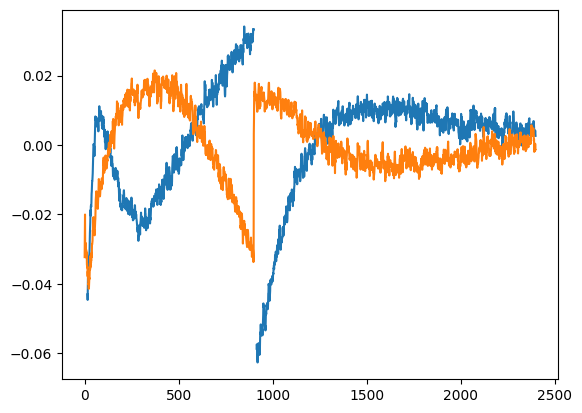

In [59]:
plt.plot(new_y[0])
plt.plot(exp.result.residual[:2400])

In [60]:
len(exp.result.residual)

28768

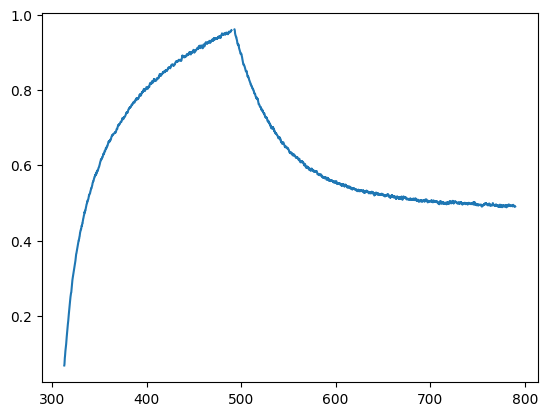

In [61]:
y = np.concatenate(new_y)
y.shape
plt.plot(x, r)

In [62]:
no = x[]
exp.result.residuals

SyntaxError: invalid syntax (436576521.py, line 1)

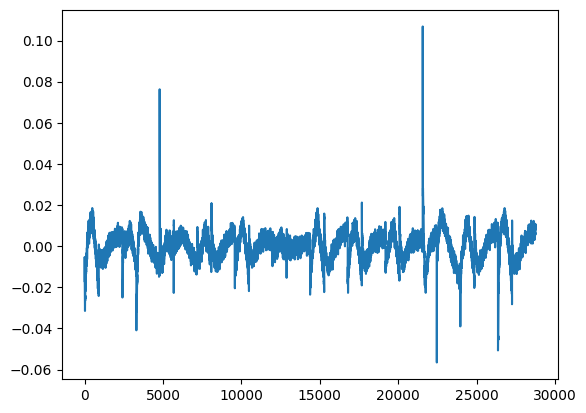

In [ ]:
plt.plot(exp.result.residual)

In [ ]:
fig.write_image(f'{exp_name}.png')

In [ ]:
from lmfit.printfuncs import fitreport_html_table
s = fitreport_html_table(exp.result, show_correl=True,  min_correl=0.1)

with open(f"{exp_name}.htm", 'w') as f: 
    f.write(s)


In [ ]:
from uncertainties import ufloat
def get_html_report(show_correl=True):
    result = exp.result
    tables = result._repr_html_(show_correl=show_correl)
    
    if ('ka' in result.params) and ('kd' in result.params):
        t = []
        cell = lambda x, tag: f'<{tag}> {x} </{tag}>'
        
        has_er = hasattr(result.params['ka'], 'stderr') and (result.params['ka'].stderr is not None)

        if has_er:
            ka = ufloat(float(result.params['ka'].value), float(result.params['ka'].stderr))
            kd = ufloat(float(result.params['kd'].value), float(result.params['kd'].stderr))
            Kd = kd/ka
        else:
            Kd = result.params['kd'].value/result.params['ka'].value

        t.append('<h2>Dissociation constant</h2>')
        t.append('<table><tr>')
        t.append(cell(f"<b>Name</b>", 'td'))
        t.append(cell(f"<b>value</b>", 'td'))
        t.append(cell(f"<b>standard error</b>", 'td'))
        t.append(cell(f"<b>relative error</b>", 'td'))  
        t.append('</tr><tr>')
        t.append(cell(f"<b>Kd</b>", 'td'))
        if has_er:
            t.append(cell(f"{Kd.n:.5e}", 'td'))
            t.append(cell(f"{Kd.std_dev:.5e}", 'td'))
            t.append(cell(f"{Kd.std_dev/Kd.n:.2%}", 'td'))
        else:
            t.append(cell(f"{Kd:.5e}", 'td'))
            t.append(cell("NA", 'td'))
            t.append(cell("NA", 'td'))
        t.append('</table></tr></table>')

        return tables + ''.join(t)
    
    else: 
        return tables

report = get_html_report(show_correl=False)
with open(f'{exp_name}_extended_report.htm','w') as f:
    f.write(report)

In [ ]:
exp.result

In [ ]:
r = []
for ds in exp:
    if ds.use_for_fit == False: continue
    r.append(ds.response)



In [ ]:
re = np.concatenate(r)
re = re[~np.isnan(re)]

In [ ]:
1 - exp.result.residual.var() / np.var(re)

0.998721227139604

In [ ]:
0.02086640/3511.98666	

5.941480426921667e-06

In [ ]:
exp.result